<a href="https://colab.research.google.com/github/benkrikler/wavefilter/blob/main/notebooks/develop_simple_pulse_finder_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install "git+https://github.com/benkrikler/wavefilter#egg=wavefilter"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/benkrikler/wavefilter to /tmp/pip-install-_ofpyem1/wavefilter_43c572da44b94426b513a5a9b96c842b
  Running command git clone -q https://github.com/benkrikler/wavefilter /tmp/pip-install-_ofpyem1/wavefilter_43c572da44b94426b513a5a9b96c842b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for wavefilter: filename=wavefilter-0.0.1-py3-none-any.whl size=5179 sha256=d4b52e8f99048245e84a8ddfee5cc036c0cd9893c0d58177d18723871dda2837
  Stored in directory: /tmp/pip-ephem-wheel-cache-uqnbx5mo/wheels/90/df/9f/9270370fe3646030b374f3d85d149fae54db3182db8119bb26
Successfully built wavefilter


In [2]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
import wavefilter.datasets as wds
import wavefilter.pulse_functions as wps
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [58]:
class GlobalSoftMaxAttention(nn.Module):
  def __init__(self):
      super().__init__()

  def forward(self, ampl, original):
      return F.softmax(ampl, -1)

class Conv1dPulseFinderAttention(nn.Module):
  def __init__(self, length, use_amplitude=True):
      super().__init__()
      self.use_amplitude = use_amplitude
      self.pulse_finder = nn.Conv1d(1, 1, length, padding="same")
      n_channels = 2 + int(use_amplitude)
      self.combine = nn.Conv1d(n_channels, 1, 3, padding="same")

  def forward(self, ampl, original):
    pf = self.pulse_finder(original)
    inputs = (original, pf)
    if self.use_amplitude:
      inputs += (ampl,)
    concat = torch.concat(inputs, dim=-2)
    encoded = self.combine(concat)
    encoded = torch.sigmoid(encoded)
    #return encoded
    return F.softmax(encoded, -1)
"""
  def forward(self, ampl, original):
    pf = self.pulse_finder(original)
    inputs = (original, pf)
    if self.use_amplitude:
      inputs += (ampl,)
    concat = torch.concat(inputs, dim=-2)
    encoded = torch.tanh(F.softshrink(self.combine(concat)))
    return F.softmax(encoded, -1
"""
# Use inspiration from https://stackoverflow.com/a/67347262
class TiedFlippedConvolve1D(nn.Module):
  def __init__(self, tied_to):
      super().__init__()
      self.tied_to = tied_to
      self.bias = nn.Parameter(torch.Tensor(1))
      self.reset_parameters()

  def reset_parameters(self):
      nn.init.uniform_(self.bias, -1, 1)

  def forward(self, x):
      return F.conv1d(x, torch.flip(self.tied_to.weight, [-1]), self.bias, padding="same")

class WaveFilter(nn.Module):
    def __init__(self, kernel_size, encoder):
      super().__init__()
      self.convolve = nn.Conv1d(1, 1, kernel_size, padding="same")
      self.encode = encoder
      self.reconstruct = TiedFlippedConvolve1D(self.convolve)

    def forward(self, input):
        ampl = self.convolve(input)
        encoded = ampl * self.encode(ampl, input)
        #encoded = ampl * F.softmax(ampl, -1)
        output = self.reconstruct(encoded)
        #output = F.conv1d(encoded, torch.flip(self.convolve.weight, [-1]), self.out_bias, padding="same")
        return output

class CaptureActivations:
  def __init__(self):
    self.activations = {}
  
  def __getitem__(self, name):
    return self.activations[name]

  def __call__(self, name):
    def hook(model, input, output):
        self.activations[name] = output.detach()
    return hook
  
  def register(self, model, *layers):
    for layer in layers:
      getattr(model, layer).register_forward_hook(self(layer))

model = WaveFilter(200, Conv1dPulseFinderAttention(100, False)).to(device)
#model = WaveFilter(200, GlobalSoftMaxAttention()).to(device)
activations = CaptureActivations()
activations.register(model, "encode", "convolve", "reconstruct")
activations.register(model.encode, "pulse_finder", "combine")
print(model)

WaveFilter(
  (convolve): Conv1d(1, 1, kernel_size=(200,), stride=(1,), padding=same)
  (encode): Conv1dPulseFinderAttention(
    (pulse_finder): Conv1d(1, 1, kernel_size=(100,), stride=(1,), padding=same)
    (combine): Conv1d(2, 1, kernel_size=(3,), stride=(1,), padding=same)
  )
  (reconstruct): TiedFlippedConvolve1D(
    (tied_to): Conv1d(1, 1, kernel_size=(200,), stride=(1,), padding=same)
  )
)


In [4]:
# Based on https://medium.com/nerd-for-tech/convolution-neural-network-in-pytorch-81023e7de5b9
class TrainTester:
    def __init__(self, model, learning_rate, device, loss):
        self.model = model
        self.lr = learning_rate
        self.loss = loss
        self.opt = torch.optim.Adam(self.model.parameters(), lr = self.lr)
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []
        self.device = device

    def batch_accuracy(self, output, target):
        # output shape: [batch, 10]
        output = nn.functional.softmax(output, dim=1)
        output = output.argmax(1)    
        acc = torch.sum(output==target) / output.shape[0]
        return acc.cpu()*100    

    def train_step(self, dataset):
        self.model.train()
        batch_loss = []
        batch_acc = []
        for batch in dataset:
            inputs = batch[0].to(self.device)
            targets = inputs
            #targets = batch[1].to(self.device)
            self.opt.zero_grad() 
           
            outputs = self.model(inputs)

            loss = self.loss(outputs, targets)
            loss.backward()
            self.opt.step()
            batch_loss.append(loss.item())
            batch_acc.append(self.batch_accuracy(outputs,targets))
        
        self.train_loss.append(np.mean(batch_loss))
        self.train_acc.append(np.mean(batch_acc))

    def validation_step(self, dataset):
        self.model.eval()
        batch_loss = []
        batch_acc = []
        with torch.no_grad():
            for batch in dataset:
                inputs = batch[0].to(self.device)
                targets = inputs
                # targets = batch[1].to(self.device)
            
                outputs = self.model(inputs)

                loss = self.loss(outputs, targets)
                batch_loss.append(loss.item())
                batch_acc.append(self.batch_accuracy(outputs,targets))

        self.val_loss.append(np.mean(batch_loss))
        self.val_acc.append(np.mean(batch_acc))

    def test_step(self, dataset):
        self.model.eval()
        batch_acc = []
        with torch.no_grad():
            for batch in dataset:
                inputs = batch[0].to(self.device)
                targets = inputs
                #targets = batch[1].to(self.device)
            
                outputs = self.model(inputs)
                batch_acc.append(self.batch_accuracy(outputs,targets))
            
        print("Accuracy : ", np.mean(batch_acc), "%")

In [21]:
data, truth = wds.generate_double_pulse_dataset(10000, in_noise=0.05, out_noise=2, shape=40, dt2_low=150, dt2_high=700)
# Add an extra dimension for the channel number
data = data[:, np.newaxis, :]
data = torch.tensor(data)
data

tensor([[[-0.2910, -1.7047, -1.5224,  ..., -0.5059,  2.9286,  3.8407]],

        [[ 0.8840, -1.7787,  0.6993,  ...,  0.6697,  3.6064, -1.4194]],

        [[-1.2604,  3.8194, -1.5284,  ...,  0.4526, -1.1607, -0.0804]],

        ...,

        [[-1.8156, -2.5107, -0.5291,  ..., -2.0099, -0.0414,  0.0394]],

        [[-4.9491, -1.7566, -0.7622,  ...,  0.5668,  0.2132, -1.5245]],

        [[-0.9654, -3.2961,  2.2607,  ...,  1.3227, -0.7780, -1.3366]]])

In [6]:
ds = torch.utils.data.TensorDataset(data)
train_loader = torch.utils.data.DataLoader(ds,batch_size=100,shuffle=False)
for i, d in enumerate(train_loader):
  print(f"i={i}")
  print([(dd.shape, dd.mean) for dd in d])
  if i > 2: 
    break

i=0
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7f339ce19cb0>)]
i=1
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7f3319d0e950>)]
i=2
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7f3398275b30>)]
i=3
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7f3319d218f0>)]


In [59]:
import tqdm
learning_rate = 1e-3
batch_size = 64
epochs = 100
train_test_runner = TrainTester(model, learning_rate, device, nn.MSELoss())

for epoch in tqdm.notebook.tqdm(range(epochs), desc='Epoch'):
    train_test_runner.train_step(train_loader)
    #train_test_runner.validation_step(val_loader)
#train_test_runner.test_step(test_loader)

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

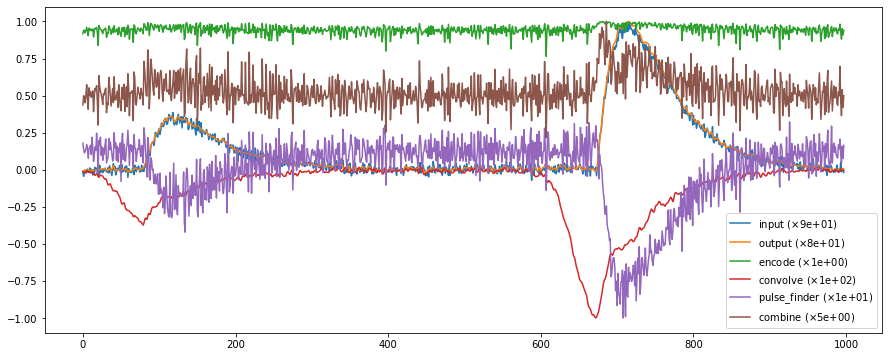

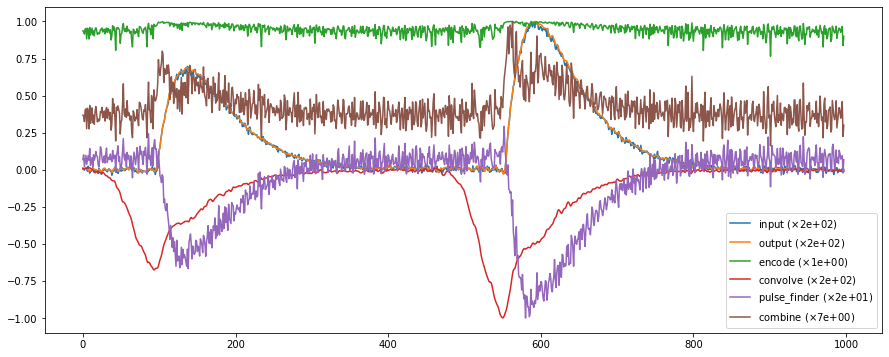

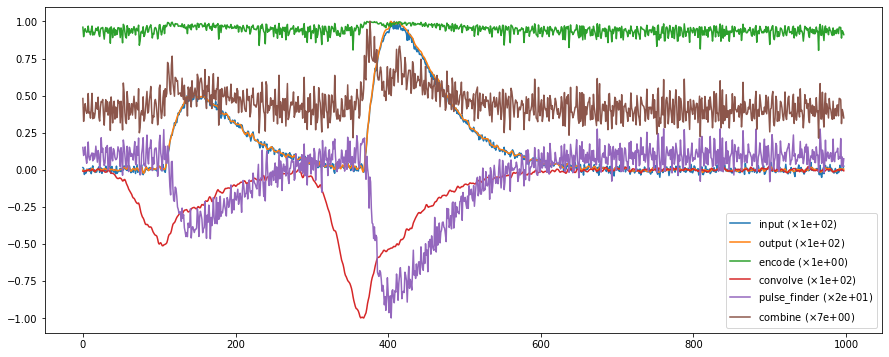

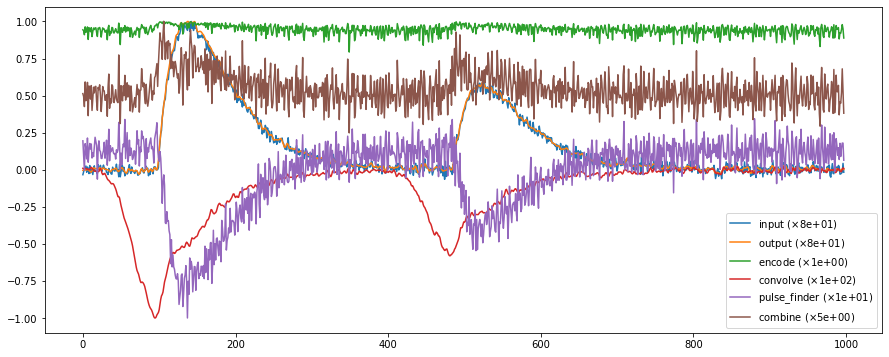

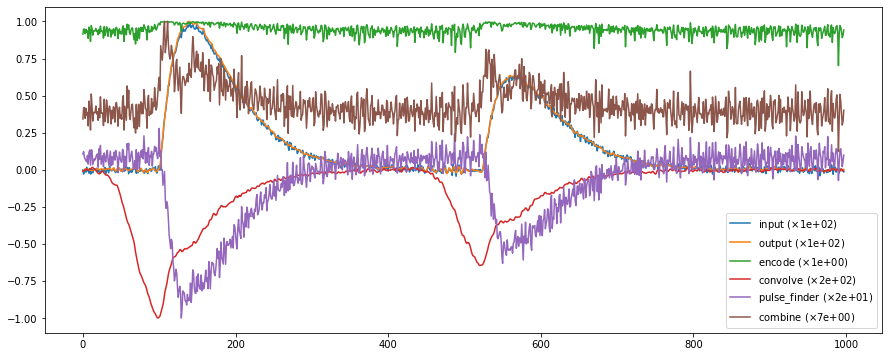

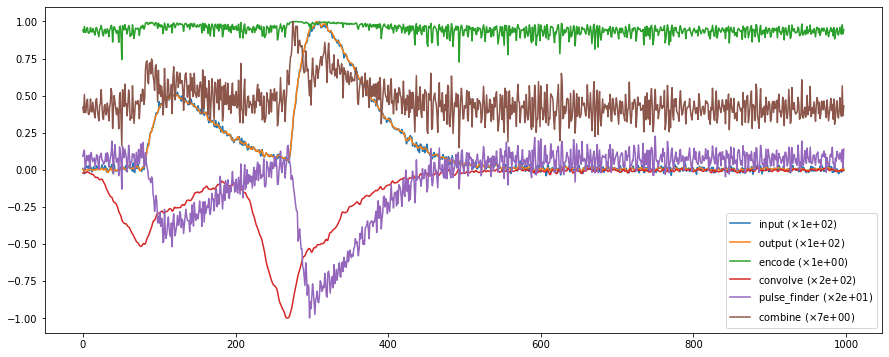

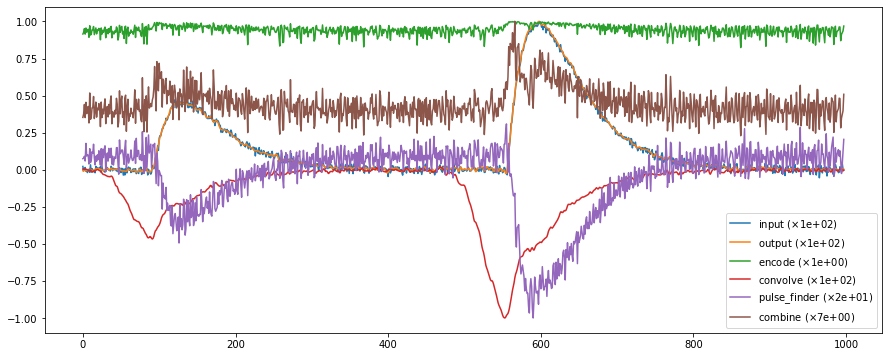

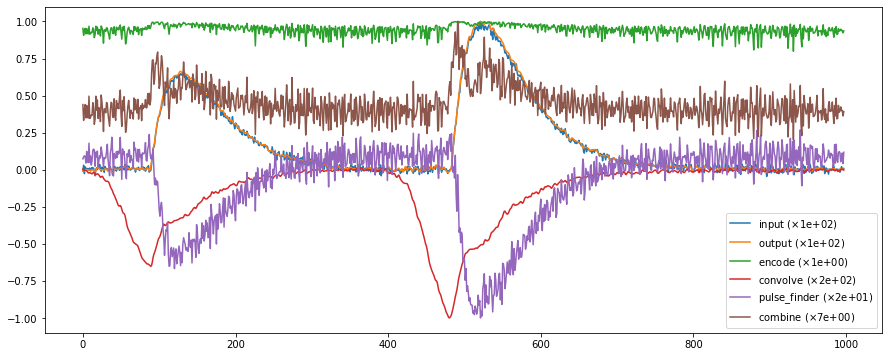

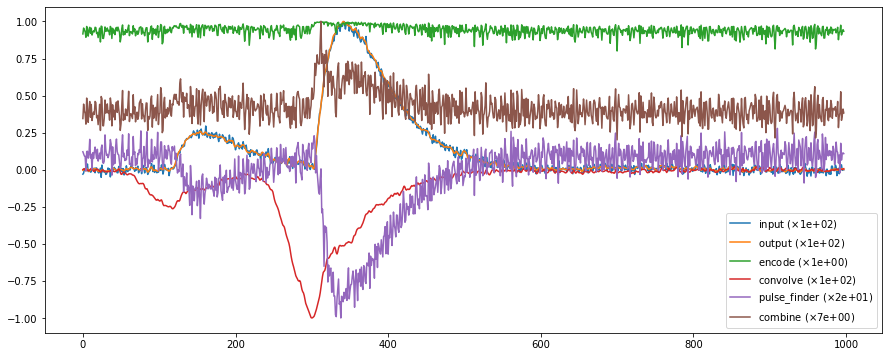

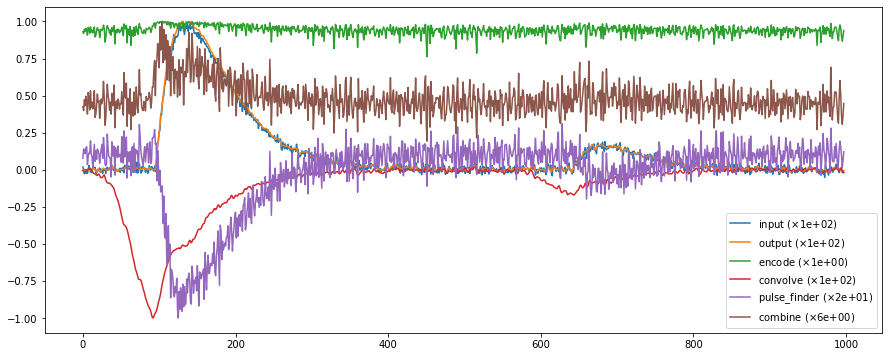

In [60]:
def plot_line(data, label):
  scale = max(data.max(), -data.min())
  return plt.plot(data / scale, label=f"{label} ($\\times${scale:.01})")

def plot_prediction(model, input):
  output = model(input.to(device))
  plot_line(input[0], label="input")
  plot_line(output[0].detach().cpu().numpy(), label="output")
  for i in ["encode", "convolve", "pulse_finder", "combine"]:
    plot_line(activations[i][0].cpu(), label=i)
  plt.legend()

for i in np.random.randint(len(data), size=10):
  plt.figure(figsize=(15,6))
  plot_prediction(model, ds[i][0])

In [50]:
for n, p in model.named_parameters():
  print(n, p)

convolve.weight Parameter containing:
tensor([[[ 0.0355,  0.0380,  0.0253,  0.0073, -0.0110, -0.0175, -0.0144,
          -0.0039,  0.0062,  0.0035, -0.0187, -0.0404, -0.0397, -0.0277,
          -0.0258, -0.0190, -0.0095,  0.0010,  0.0010,  0.0003,  0.0130,
           0.0286,  0.0372,  0.0426,  0.0412,  0.0265,  0.0056, -0.0067,
          -0.0101, -0.0110, -0.0045, -0.0009, -0.0137, -0.0255, -0.0271,
          -0.0351, -0.0345, -0.0166, -0.0184, -0.0414, -0.0439, -0.0319,
          -0.0209,  0.0003,  0.0172,  0.0170,  0.0212,  0.0386,  0.0446,
           0.0355,  0.0557,  0.0477, -0.0163,  0.0517,  0.0906,  0.0445,
          -0.0105, -0.0187,  0.0503, -0.0445, -0.0171,  0.0404, -0.0429,
          -0.0916, -0.1032, -0.0074, -0.0149, -0.0362, -0.0079, -0.0569,
          -0.0747, -0.0583,  0.0362, -0.0084,  0.0322, -0.0323, -0.0653,
          -0.0270,  0.0558,  0.0907,  0.0722, -0.0424, -0.0863, -0.0524,
          -0.0548,  0.0044,  0.0581,  0.0531,  0.0545, -0.0108,  0.0157,
           0.

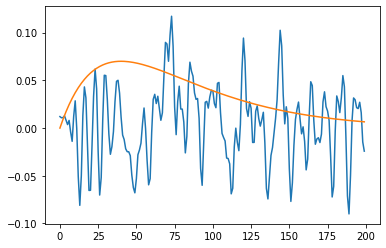

In [43]:
learnt = model.get_parameter("convolve.weight").detach().cpu().numpy()[0,0]
plt.plot(learnt)
expected = wps.simple(np.arange(200), 40)
expected = expected / expected[100]* learnt[100]
plt.plot(expected)

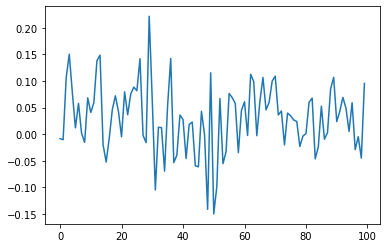

In [44]:
learnt = model.get_parameter("encode.pulse_finder.weight").detach().cpu().numpy()[0,0]
plt.plot(learnt)

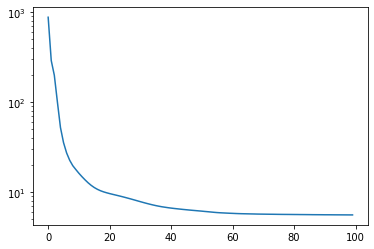

In [30]:
plt.plot(train_test_runner.train_loss);
plt.yscale("log")